# Exercise: Benchmark Different Minimum Segment Sizes

In this notebook we will discuss the `minimum_segment_size` conversion parameter, and will ask you to experiment with the value, observing how it impacts throughput in optimized models.

Additionally, you will perform conversion for 2 additional models, VGG19 and InceptionV3.

## Objectives

By the end of this notebook you will be able to:

- Conduct experiments to understand the impact of the minimum segment size conversion parameter on a variety of models

## Imports

In [1]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [2]:
from lab_helpers import (
    get_images, batch_input, load_tf_saved_model,
    predict_and_benchmark_throughput_from_saved, display_prediction_info
)

## Minimum Segment Size Conversion Parameter

The success of a TF-TRT optimization task is also dependent on the architecture of the model. The more supporting layers comprising the model, the greater number of TF-TRT layers generated and consequently, higher performance is achieved.

The `minimum_segment_size` conversion parameter determines the minimum number of nodes required for a subgraph to be replaced by an optimized TF-TRT op. While its default value of 3 tends to offer the best performance for most models, adjusting this value can have varying impact on different models.

For even more on the impacts of this parameter, see the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/#min-nodes).

## VGG19 and InceptionV3 Models

In this notebook we will utilize 2 additional models: **VGG19** and **InceptionV3**. Execute the following cells to load them, and save them to file, so that they are in the format TF-TRT expects. Feel free to continue reading while the models save.

In [3]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
vgg19_model = VGG19(weights='imagenet')
inception_v3_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [5]:
vgg19_model.save('vgg19_saved_model')
inception_v3_model.save('inception_v3_saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vgg19_saved_model/assets
INFO:tensorflow:Assets written to: inception_v3_saved_model/assets


### Batch Input for Additional Models

Before we performance inference (and benchmark), we need to batch our input.

Our `batch_input` helper function performs model-specific image preprocessing. Therefore we create one set of batched images for each of the 2 additional models. If you're interested, check out `lab_helpers.py` for the source code.

In [6]:
number_of_images = 16
images = get_images(number_of_images)

In [7]:
vgg19_batched_input = batch_input(images, model="vgg19")

In [8]:
inception_v3_batched_input = batch_input(images, model="inception_v3")

## Benchmark Different Minimum Segment Sizes

As you can see, the default value for `minimum_segment_size` is `3`.

In [9]:
trt.DEFAULT_TRT_CONVERSION_PARAMS

TrtConversionParams(rewriter_config_template=None, max_workspace_size_bytes=1073741824, precision_mode='FP32', minimum_segment_size=3, is_dynamic_op=True, maximum_cached_engines=1, use_calibration=True, max_batch_size=1)

For this exercise you are asked to optimize the  **vgg_19** and **inception_v3** models, varying `minimum_segment_size` to maximize throughput (on FP16 mode only).

### Allow for Different Minimum Segment Size Values

As you can see, `convert_to_trt_graph_and_save` now accepts a `minimum_segment_size` argument, which can be used to control the minimum segment size during conversion to a TF-TRT optimized model. Read the comments to see pertinent changes to our helper function.

In [10]:
def convert_to_trt_graph_and_save(
    precision_mode='float16',
    input_saved_model_dir='vgg19_saved_model',
    max_batch_size=16,
    # Allow for control of minimum_segment_size value
    minimum_segment_size=3
):
    precision_mode = trt.TrtPrecisionMode.FP16
    converted_save_suffix = '_TFTRT_FP16'
    
        
    if minimum_segment_size != 3:
        # Adjust filename for a given minimum segment size
        converted_save_suffix += '_MSS_{}'.format(str(minimum_segment_size))
        
    output_saved_model_dir = input_saved_model_dir + converted_save_suffix
    
    conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
        precision_mode=precision_mode, 
        max_workspace_size_bytes=8000000000,
        max_batch_size=max_batch_size,
        # Pass in adjusted minimum segment size to conversion parameters
        minimum_segment_size=minimum_segment_size
    )

    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_saved_model_dir,
        conversion_params=conversion_params
    )

    print('Converting {} to TF-TRT graph precision mode {}...'.format(input_saved_model_dir, precision_mode))
    
    converter.convert()

    print('Saving converted model to {}...'.format(output_saved_model_dir))
    converter.save(output_saved_model_dir=output_saved_model_dir)
    print('Complete')

### Benchmarking Table

As you perform the following operations, use this table to track your results.

### Benchmark Different Minimum Segment Sizes for VGG19

Run the following cells, adjusting `minimum_segment_size` so that you can observe the impact of its value when using VGG19.

#### MSS = 1

In [11]:
model_name = 'vgg19'
minimum_segment_size = 1 # TODO: Optimize for minimum segment sizes of 1 and 5

In [12]:
input_saved_model_dir = '{}_saved_model'.format(model_name) # See above for where we saved the model

convert_to_trt_graph_and_save(precision_mode='float16',
                              minimum_segment_size=minimum_segment_size, # Here we control minimum segment size for the conversion
                              input_saved_model_dir=input_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 0, 0)
Converting vgg19_saved_model to TF-TRT graph precision mode FP16...
Saving converted model to vgg19_saved_model_TFTRT_FP16_MSS_1...
INFO:tensorflow:Could not find TRTEngineOp_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: vgg19_saved_model_TFTRT_FP16_MSS_1/assets
Complete


In [13]:
infer = load_tf_saved_model('{}_saved_model_TFTRT_FP16_MSS_{}'.format(model_name, str(minimum_segment_size)))

Loading saved model vgg19_saved_model_TFTRT_FP16_MSS_1...


In [14]:
# We use batched input, and process predictions, specifically for VGG19
# Record Throughput in the table above
all_preds = predict_and_benchmark_throughput_from_saved(vgg19_batched_input, infer, N_run=150, N_warmup_run=50, model='vgg19')

Steps 0-50 average:  9.5ms
Steps 50-100 average:  9.5ms
Steps 100-150 average:  9.5ms
Throughput: 1692 images/s


Optionally, display prediction info for this model.

./data/coco/CS/nuremberg_000000_000453_leftImg8bit.png
[('n04335435', 'streetcar', 0.30402863), ('n06874185', 'traffic_light', 0.21173126)]


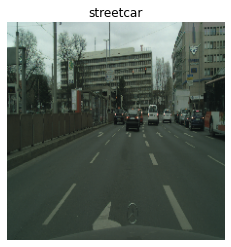

./data/coco/CS/nuremberg_000000_000454_leftImg8bit.png
[('n06874185', 'traffic_light', 0.33879712), ('n04487081', 'trolleybus', 0.15277861)]


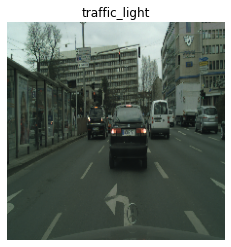

./data/coco/CS/nuremberg_000000_000455_leftImg8bit.png
[('n04487081', 'trolleybus', 0.44669113), ('n06874185', 'traffic_light', 0.21422541)]


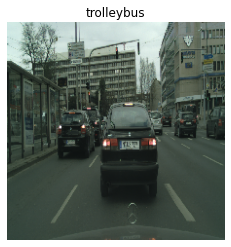

./data/coco/CS/nuremberg_000000_000456_leftImg8bit.png
[('n04487081', 'trolleybus', 0.8299261), ('n03417042', 'garbage_truck', 0.036844242)]


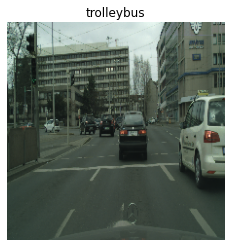

./data/coco/CS/nuremberg_000000_000457_leftImg8bit.png
[('n04487081', 'trolleybus', 0.22430916), ('n02930766', 'cab', 0.17253001)]


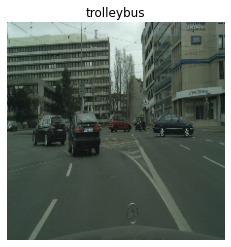

./data/coco/CS/nuremberg_000000_000458_leftImg8bit.png
[('n04486054', 'triumphal_arch', 0.19662829), ('n04335435', 'streetcar', 0.10199278)]


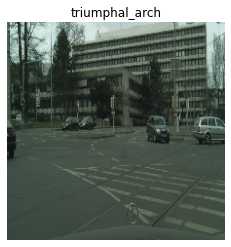

./data/coco/CS/nuremberg_000000_000459_leftImg8bit.png
[('n03837869', 'obelisk', 0.23258214), ('n04486054', 'triumphal_arch', 0.17303762)]


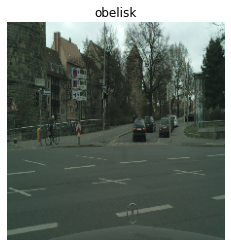

./data/coco/CS/nuremberg_000000_000460_leftImg8bit.png
[('n02825657', 'bell_cote', 0.16789362), ('n04562935', 'water_tower', 0.15081523)]


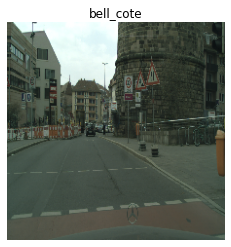

./data/coco/CS/nuremberg_000000_000461_leftImg8bit.png
[('n03788195', 'mosque', 0.16522771), ('n03220513', 'dome', 0.12452193)]


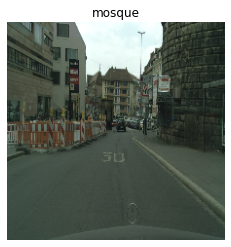

./data/coco/CS/nuremberg_000000_000462_leftImg8bit.png
[('n04335435', 'streetcar', 0.77701694), ('n04487081', 'trolleybus', 0.093345635)]


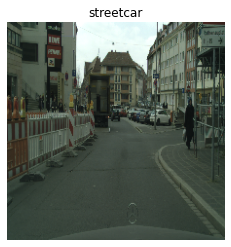

./data/coco/CS/nuremberg_000000_000463_leftImg8bit.png
[('n04487081', 'trolleybus', 0.25330707), ('n03417042', 'garbage_truck', 0.23304117)]


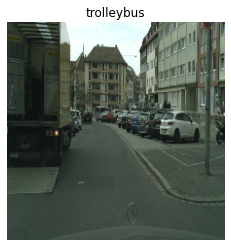

./data/coco/CS/nuremberg_000000_000464_leftImg8bit.png
[('n02930766', 'cab', 0.21438374), ('n04487081', 'trolleybus', 0.1575762)]


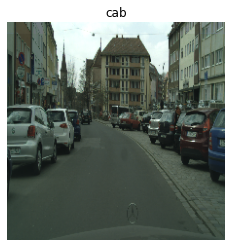

./data/coco/CS/nuremberg_000000_000465_leftImg8bit.png
[('n04487081', 'trolleybus', 0.3232077), ('n03417042', 'garbage_truck', 0.1566921)]


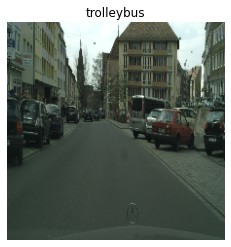

./data/coco/CS/nuremberg_000000_000466_leftImg8bit.png
[('n04335435', 'streetcar', 0.34680402), ('n06874185', 'traffic_light', 0.08281783)]


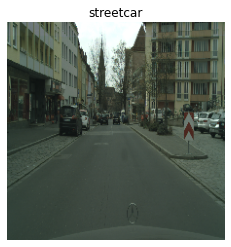

./data/coco/CS/nuremberg_000000_000467_leftImg8bit.png
[('n04335435', 'streetcar', 0.4283215), ('n04487081', 'trolleybus', 0.28476334)]


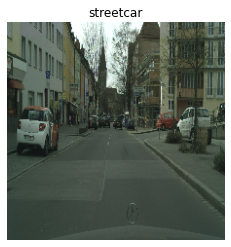

./data/coco/CS/nuremberg_000000_000468_leftImg8bit.png
[('n04335435', 'streetcar', 0.5010131), ('n04487081', 'trolleybus', 0.33570382)]


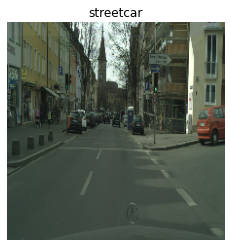

In [15]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, model='vgg19')

#### MSS = 5

In [16]:
model_name = 'vgg19'
minimum_segment_size = 5 # TODO: Optimize for minimum segment sizes of 1 and 5

In [17]:
input_saved_model_dir = '{}_saved_model'.format(model_name) # See above for where we saved the model

convert_to_trt_graph_and_save(precision_mode='float16',
                              minimum_segment_size=minimum_segment_size, # Here we control minimum segment size for the conversion
                              input_saved_model_dir=input_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 0, 0)
Converting vgg19_saved_model to TF-TRT graph precision mode FP16...
Saving converted model to vgg19_saved_model_TFTRT_FP16_MSS_5...
INFO:tensorflow:Assets written to: vgg19_saved_model_TFTRT_FP16_MSS_5/assets
Complete


In [20]:
infer = load_tf_saved_model('{}_saved_model_TFTRT_FP16_MSS_{}'.format(model_name, str(minimum_segment_size)))

Loading saved model vgg19_saved_model_TFTRT_FP16_MSS_5...


In [21]:
# We use batched input, and process predictions, specifically for VGG19
# Record Throughput in the table above
all_preds = predict_and_benchmark_throughput_from_saved(vgg19_batched_input, infer, N_run=150, N_warmup_run=50, model='vgg19')

Steps 0-50 average:  9.5ms
Steps 50-100 average:  9.5ms
Steps 100-150 average:  9.5ms
Throughput: 1689 images/s


./data/coco/CS/nuremberg_000000_000453_leftImg8bit.png
[('n04335435', 'streetcar', 0.30402863), ('n06874185', 'traffic_light', 0.21173126)]


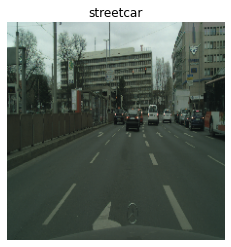

./data/coco/CS/nuremberg_000000_000454_leftImg8bit.png
[('n06874185', 'traffic_light', 0.33879712), ('n04487081', 'trolleybus', 0.15277861)]


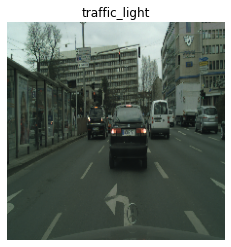

./data/coco/CS/nuremberg_000000_000455_leftImg8bit.png
[('n04487081', 'trolleybus', 0.44669113), ('n06874185', 'traffic_light', 0.21422541)]


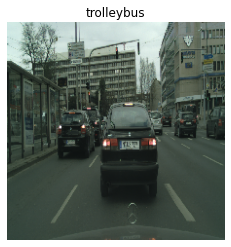

./data/coco/CS/nuremberg_000000_000456_leftImg8bit.png
[('n04487081', 'trolleybus', 0.8299261), ('n03417042', 'garbage_truck', 0.036844242)]


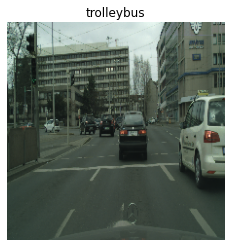

./data/coco/CS/nuremberg_000000_000457_leftImg8bit.png
[('n04487081', 'trolleybus', 0.22430916), ('n02930766', 'cab', 0.17253001)]


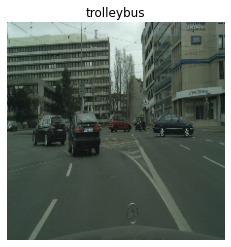

./data/coco/CS/nuremberg_000000_000458_leftImg8bit.png
[('n04486054', 'triumphal_arch', 0.19662829), ('n04335435', 'streetcar', 0.10199278)]


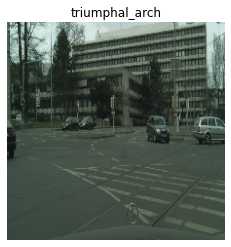

./data/coco/CS/nuremberg_000000_000459_leftImg8bit.png
[('n03837869', 'obelisk', 0.23258214), ('n04486054', 'triumphal_arch', 0.17303762)]


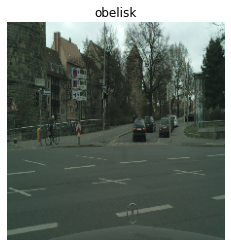

./data/coco/CS/nuremberg_000000_000460_leftImg8bit.png
[('n02825657', 'bell_cote', 0.16789362), ('n04562935', 'water_tower', 0.15081523)]


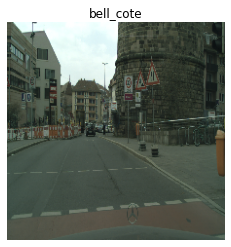

./data/coco/CS/nuremberg_000000_000461_leftImg8bit.png
[('n03788195', 'mosque', 0.16522771), ('n03220513', 'dome', 0.12452193)]


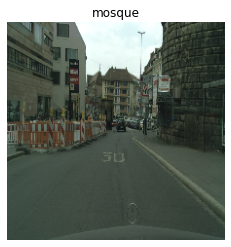

./data/coco/CS/nuremberg_000000_000462_leftImg8bit.png
[('n04335435', 'streetcar', 0.77701694), ('n04487081', 'trolleybus', 0.093345635)]


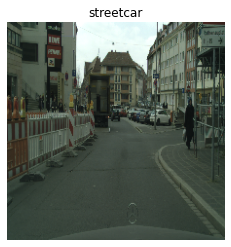

./data/coco/CS/nuremberg_000000_000463_leftImg8bit.png
[('n04487081', 'trolleybus', 0.25330707), ('n03417042', 'garbage_truck', 0.23304117)]


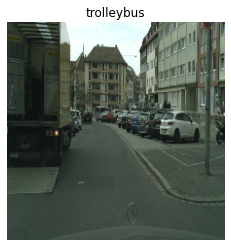

./data/coco/CS/nuremberg_000000_000464_leftImg8bit.png
[('n02930766', 'cab', 0.21438374), ('n04487081', 'trolleybus', 0.1575762)]


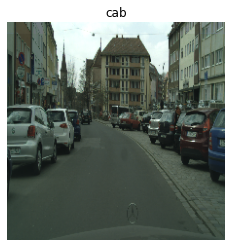

./data/coco/CS/nuremberg_000000_000465_leftImg8bit.png
[('n04487081', 'trolleybus', 0.3232077), ('n03417042', 'garbage_truck', 0.1566921)]


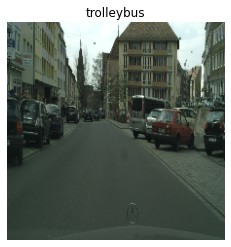

./data/coco/CS/nuremberg_000000_000466_leftImg8bit.png
[('n04335435', 'streetcar', 0.34680402), ('n06874185', 'traffic_light', 0.08281783)]


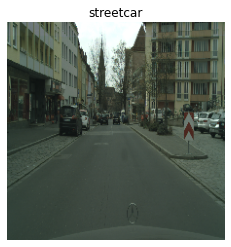

./data/coco/CS/nuremberg_000000_000467_leftImg8bit.png
[('n04335435', 'streetcar', 0.4283215), ('n04487081', 'trolleybus', 0.28476334)]


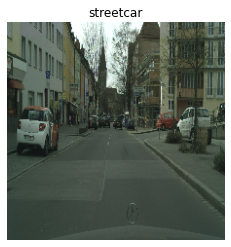

./data/coco/CS/nuremberg_000000_000468_leftImg8bit.png
[('n04335435', 'streetcar', 0.5010131), ('n04487081', 'trolleybus', 0.33570382)]


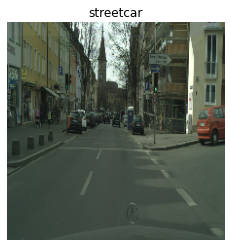

In [22]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, model='vgg19')

### Benchmark Different Minimum Segment Sizes for InceptionV3

Run the following cells, adjusting `minimum_segment_size` so that you can observe the impact of its value when using InceptionV3.

#### MSS = 1

In [23]:
model_name = 'inception_v3'
minimum_segment_size = 1 # TODO: Optimize for minimum segment sizes of 1 and 5

In [24]:
input_saved_model_dir = '{}_saved_model'.format(model_name) # See above for where we saved the model

convert_to_trt_graph_and_save(precision_mode='float16',
                              minimum_segment_size=minimum_segment_size, # Here we control minimum segment size for the conversion
                              input_saved_model_dir=input_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 0, 0)
Converting inception_v3_saved_model to TF-TRT graph precision mode FP16...
Saving converted model to inception_v3_saved_model_TFTRT_FP16_MSS_1...
INFO:tensorflow:Could not find TRTEngineOp_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: inception_v3_saved_model_TFTRT_FP16_MSS_1/assets
Complete


In [25]:
infer = load_tf_saved_model('{}_saved_model_TFTRT_FP16_MSS_{}'.format(model_name, str(minimum_segment_size)))

Loading saved model inception_v3_saved_model_TFTRT_FP16_MSS_1...


In [26]:
# We use batched input, and process predictions, specifically for InceptionV3
# Record Throughput in the table above
all_preds = predict_and_benchmark_throughput_from_saved(inception_v3_batched_input, infer, N_run=150, N_warmup_run=50, model='inception_v3')

Steps 0-50 average:  6.2ms
Steps 50-100 average:  6.2ms
Steps 100-150 average:  6.2ms
Throughput: 2585 images/s


Optionally, display prediction info for this model.

./data/coco/CS/nuremberg_000000_000453_leftImg8bit.png
[('n04467665', 'trailer_truck', 0.81570435), ('n03417042', 'garbage_truck', 0.11706648)]


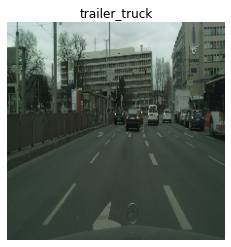

./data/coco/CS/nuremberg_000000_000454_leftImg8bit.png
[('n03977966', 'police_van', 0.70601577), ('n03417042', 'garbage_truck', 0.19418544)]


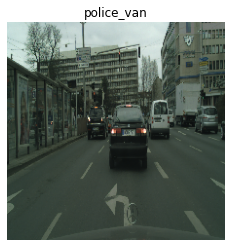

./data/coco/CS/nuremberg_000000_000455_leftImg8bit.png
[('n03417042', 'garbage_truck', 0.96538424), ('n03977966', 'police_van', 0.017712802)]


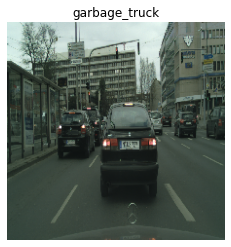

./data/coco/CS/nuremberg_000000_000456_leftImg8bit.png
[('n02930766', 'cab', 0.876033), ('n03417042', 'garbage_truck', 0.043955937)]


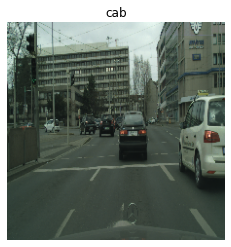

./data/coco/CS/nuremberg_000000_000457_leftImg8bit.png
[('n03417042', 'garbage_truck', 0.69173545), ('n03977966', 'police_van', 0.29571688)]


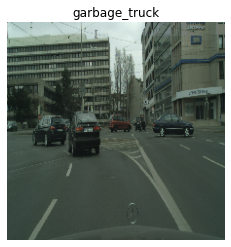

./data/coco/CS/nuremberg_000000_000458_leftImg8bit.png
[('n02930766', 'cab', 0.25048766), ('n03670208', 'limousine', 0.17845261)]


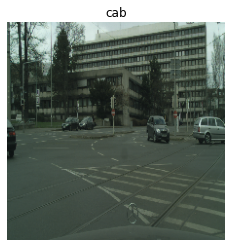

./data/coco/CS/nuremberg_000000_000459_leftImg8bit.png
[('n03837869', 'obelisk', 0.4983192), ('n06874185', 'traffic_light', 0.281937)]


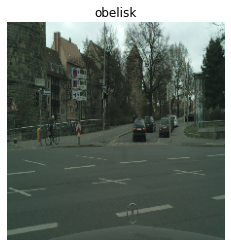

./data/coco/CS/nuremberg_000000_000460_leftImg8bit.png
[('n04346328', 'stupa', 0.46496028), ('n03956157', 'planetarium', 0.23986523)]


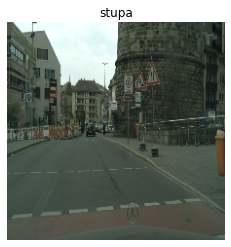

./data/coco/CS/nuremberg_000000_000461_leftImg8bit.png
[('n04335435', 'streetcar', 0.4636383), ('n02894605', 'breakwater', 0.10807979)]


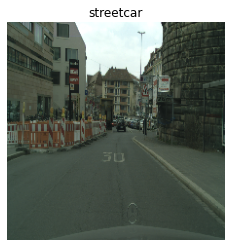

./data/coco/CS/nuremberg_000000_000462_leftImg8bit.png
[('n04335435', 'streetcar', 0.5031927), ('n04487081', 'trolleybus', 0.16475964)]


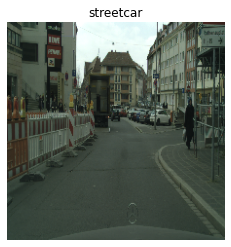

./data/coco/CS/nuremberg_000000_000463_leftImg8bit.png
[('n04335435', 'streetcar', 0.27584615), ('n04467665', 'trailer_truck', 0.23368423)]


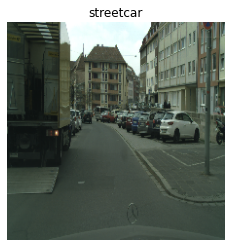

./data/coco/CS/nuremberg_000000_000464_leftImg8bit.png
[('n02930766', 'cab', 0.7626344), ('n06874185', 'traffic_light', 0.057117447)]


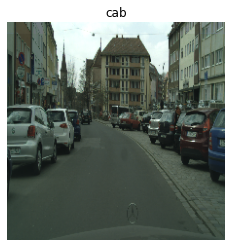

./data/coco/CS/nuremberg_000000_000465_leftImg8bit.png
[('n02930766', 'cab', 0.79090303), ('n03345487', 'fire_engine', 0.038702022)]


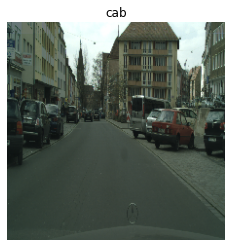

./data/coco/CS/nuremberg_000000_000466_leftImg8bit.png
[('n06874185', 'traffic_light', 0.13012129), ('n04487081', 'trolleybus', 0.10748657)]


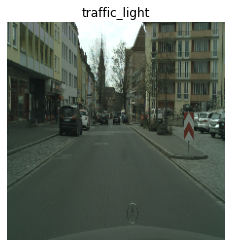

./data/coco/CS/nuremberg_000000_000467_leftImg8bit.png
[('n04486054', 'triumphal_arch', 0.71728194), ('n06874185', 'traffic_light', 0.1495331)]


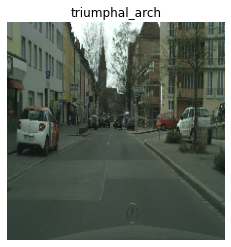

./data/coco/CS/nuremberg_000000_000468_leftImg8bit.png
[('n04335435', 'streetcar', 0.34927416), ('n04486054', 'triumphal_arch', 0.09948296)]


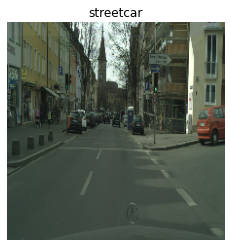

In [27]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, model='inception_v3')

#### MSS = 5

In [28]:
model_name = 'inception_v3'
minimum_segment_size = 5 # TODO: Optimize for minimum segment sizes of 1 and 5

In [29]:
input_saved_model_dir = '{}_saved_model'.format(model_name) # See above for where we saved the model

convert_to_trt_graph_and_save(precision_mode='float16',
                              minimum_segment_size=minimum_segment_size, # Here we control minimum segment size for the conversion
                              input_saved_model_dir=input_saved_model_dir)

INFO:tensorflow:Linked TensorRT version: (7, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 0, 0)
Converting inception_v3_saved_model to TF-TRT graph precision mode FP16...
Saving converted model to inception_v3_saved_model_TFTRT_FP16_MSS_5...
INFO:tensorflow:Assets written to: inception_v3_saved_model_TFTRT_FP16_MSS_5/assets
Complete


In [30]:
infer = load_tf_saved_model('{}_saved_model_TFTRT_FP16_MSS_{}'.format(model_name, str(minimum_segment_size)))

Loading saved model inception_v3_saved_model_TFTRT_FP16_MSS_5...


In [31]:
# We use batched input, and process predictions, specifically for InceptionV3
# Record Throughput in the table above
all_preds = predict_and_benchmark_throughput_from_saved(inception_v3_batched_input, infer, N_run=150, N_warmup_run=50, model='inception_v3')

Steps 0-50 average:  5.5ms
Steps 50-100 average:  5.3ms
Steps 100-150 average:  5.2ms
Throughput: 3032 images/s


./data/coco/CS/nuremberg_000000_000453_leftImg8bit.png
[('n04467665', 'trailer_truck', 0.81570435), ('n03417042', 'garbage_truck', 0.11706648)]


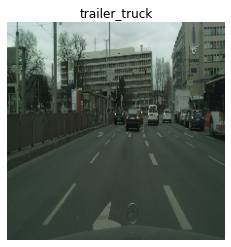

./data/coco/CS/nuremberg_000000_000454_leftImg8bit.png
[('n03977966', 'police_van', 0.70601577), ('n03417042', 'garbage_truck', 0.19418544)]


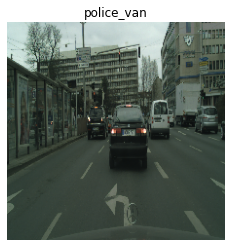

./data/coco/CS/nuremberg_000000_000455_leftImg8bit.png
[('n03417042', 'garbage_truck', 0.96538424), ('n03977966', 'police_van', 0.017712802)]


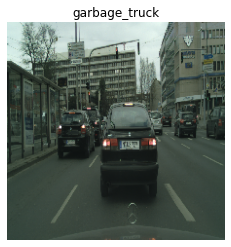

./data/coco/CS/nuremberg_000000_000456_leftImg8bit.png
[('n02930766', 'cab', 0.876033), ('n03417042', 'garbage_truck', 0.043955937)]


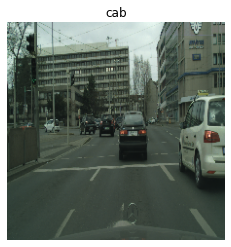

./data/coco/CS/nuremberg_000000_000457_leftImg8bit.png
[('n03417042', 'garbage_truck', 0.69173545), ('n03977966', 'police_van', 0.29571688)]


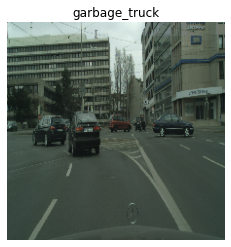

./data/coco/CS/nuremberg_000000_000458_leftImg8bit.png
[('n02930766', 'cab', 0.25048766), ('n03670208', 'limousine', 0.17845261)]


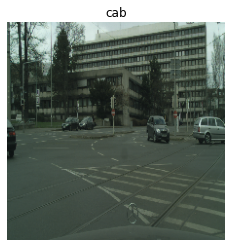

./data/coco/CS/nuremberg_000000_000459_leftImg8bit.png
[('n03837869', 'obelisk', 0.4983192), ('n06874185', 'traffic_light', 0.281937)]


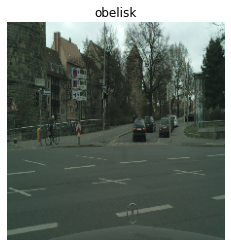

./data/coco/CS/nuremberg_000000_000460_leftImg8bit.png
[('n04346328', 'stupa', 0.46496028), ('n03956157', 'planetarium', 0.23986523)]


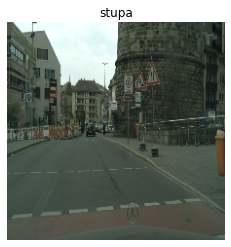

./data/coco/CS/nuremberg_000000_000461_leftImg8bit.png
[('n04335435', 'streetcar', 0.4636383), ('n02894605', 'breakwater', 0.10807979)]


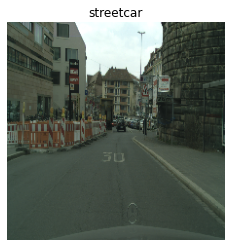

./data/coco/CS/nuremberg_000000_000462_leftImg8bit.png
[('n04335435', 'streetcar', 0.5031927), ('n04487081', 'trolleybus', 0.16475964)]


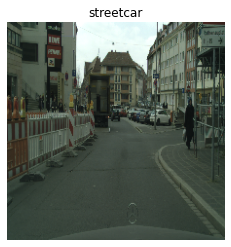

./data/coco/CS/nuremberg_000000_000463_leftImg8bit.png
[('n04335435', 'streetcar', 0.27584615), ('n04467665', 'trailer_truck', 0.23368423)]


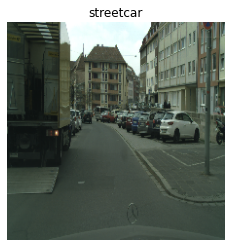

./data/coco/CS/nuremberg_000000_000464_leftImg8bit.png
[('n02930766', 'cab', 0.7626344), ('n06874185', 'traffic_light', 0.057117447)]


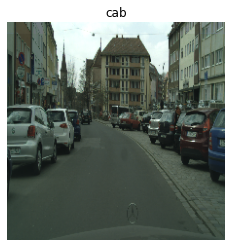

./data/coco/CS/nuremberg_000000_000465_leftImg8bit.png
[('n02930766', 'cab', 0.79090303), ('n03345487', 'fire_engine', 0.038702022)]


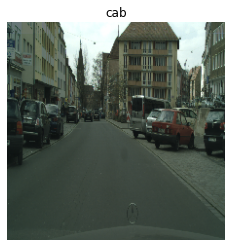

./data/coco/CS/nuremberg_000000_000466_leftImg8bit.png
[('n06874185', 'traffic_light', 0.13012129), ('n04487081', 'trolleybus', 0.10748657)]


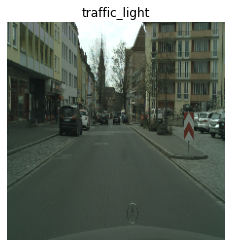

./data/coco/CS/nuremberg_000000_000467_leftImg8bit.png
[('n04486054', 'triumphal_arch', 0.71728194), ('n06874185', 'traffic_light', 0.1495331)]


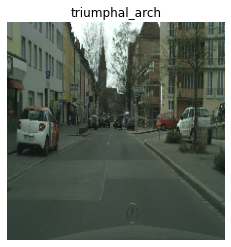

./data/coco/CS/nuremberg_000000_000468_leftImg8bit.png
[('n04335435', 'streetcar', 0.34927416), ('n04486054', 'triumphal_arch', 0.09948296)]


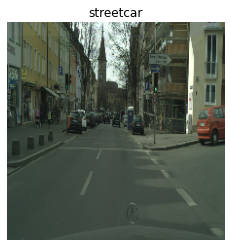

In [32]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, model='inception_v3')

## Restart Kernel

Please execute the cell below to restart the kernel and clear GPU memory.

In [33]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}